# Patch Perfect

In [ ]:
!python3 -m pip install inference roboflow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of awscli to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.7/594.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.0/906.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

## Load Model from RoboFlow and Predict Potholes

### Run Object Detection on Train Images

In [ ]:
from roboflow import Roboflow
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import inference
# Load the model
rf = Roboflow(api_key="Ujq7MVtbrywY83z9oDsn")
project = rf.workspace("pothole").project("stick4")
model = project.version(1).model

# Define the confidence and overlap thresholds
confidence_threshold = 0.001
overlap_threshold = 0.01

# Directory where the images are located
image_directory = "drive/MyDrive/data/train_images/"

# Directory where the predictions should be saved
predictions_directory = "drive/MyDrive/data/predictions/"

# Create the predictions directory if it doesn't exist, and clear any existing files in it
if os.path.exists(predictions_directory):
    # Remove all files in the directory
    for filename in os.listdir(predictions_directory):
        file_path = os.path.join(predictions_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
else:
    # Create the directory if it doesn't exist
    os.makedirs(predictions_directory)

# Get the list of all image files in the directory
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith('.jpg')])

# Arrays to normalise data later
maxPothole = np.zeros(4)
maxStick1 = np.zeros(4)
maxStick2 = np.zeros(4)

for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    print(image_file)

    try:
        # Perform inference on the image with the specified confidence and overlap thresholds
        prediction = model.predict(image_path, confidence=confidence_threshold, overlap=overlap_threshold).json()
        print(prediction)
        # Load the image using OpenCV
        img = cv2.imread(image_path)

        if img is None:
            raise FileNotFoundError(f"Image {image_path} not found.")

        # Get image dimensions for normalization
        img_height, img_width, _ = img.shape

        # Separate the predictions by class
        pothole_boxes = []
        stick_boxes = []
        max_confidence = 0
        max_confidence1 = 0
        max_confidence2 = 0



        for bbox in prediction['predictions']:
            if bbox['class'] == '0':
                pothole_boxes.append(bbox)
            elif bbox['class'] == '1' or bbox['class'] == '2':
                stick_boxes.append(bbox)

        # Create a text file with the same name as the image file (but with a .txt extension)
        output_file_name = os.path.join(predictions_directory, f"{os.path.splitext(image_file)[0]}.txt")
        with open(output_file_name, "w") as file:
          pothole_array = np.array([-1,-1,-1,-1])
          l1_array = np.array([-1,-1,-1,-1])
          l2_array = np.array([-1,-1,-1,-1])

          # Process the 'pothole' boxes first, if they exist
          for bbox in pothole_boxes:
              confidence = bbox['confidence']
              if confidence > max_confidence:
                max_confidence = confidence
                x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                if x1 > maxPothole[0]:
                  maxPothole[0] = x1
                y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                if y1 > maxPothole[1]:
                  maxPothole[1] = y1
                width = bbox['width'] / img_width
                if width > maxPothole[2]:
                  maxPothole[2] = width
                height = bbox["height"] / img_height
                if height > maxPothole[3]:
                  maxPothole[3] = height
                box_num = bbox['class_id']
                pothole_array = np.array([x1, y1, width, height])

              # Denormalize for drawing purposes
              start_point = (int(x1 * img_width), int(y1 * img_height))
              end_point = (int((x1 + width) * img_width), int((y1 + height) * img_height))
              color = (0, 255, 0)  # Green color for bounding box
              thickness = 2  # Thickness of the bounding box
              img = cv2.rectangle(img, start_point, end_point, color, thickness)

          # Process the 'stick' boxes
          for bbox in stick_boxes:
              box_num = bbox['class_id']
              confidence = bbox['confidence']
              match box_num:
                case 1:
                  if confidence > max_confidence1:
                    max_confidence1 = confidence
                    x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                    if x1 > maxStick1[0]:
                      maxStick1[0] = x1
                    y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                    if y1 > maxStick1[1]:
                      maxStick1[1] = y1
                    width = bbox['width'] / img_width
                    if width > maxStick1[2]:
                      maxStick1[2] = width
                    height = bbox["height"] / img_height
                    if height > maxStick1[3]:
                      maxStick1[3] = height
                    l1_array = np.array([x1, y1, width, height])
                case 2:
                  if confidence > max_confidence2:
                    max_confidence2 = confidence
                    x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                    if x1 > maxStick2[0]:
                      maxStick2[0] = x1
                    y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                    if y1 > maxStick2[1]:
                      maxStick2[1] = y1
                    width = bbox['width'] / img_width
                    if width > maxStick2[2]:
                      maxStick2[2] = width
                    height = bbox["height"] / img_height
                    if height > maxStick2[3]:
                      maxStick2[3] = height
                    l2_array = np.array([x1, y1, width, height])

              # Denormalize for drawing purposes
              start_point = (int(x1 * img_width), int(y1 * img_height))
              end_point = (int((x1 + width) * img_width), int((y1 + height) * img_height))
              if box_num == 1:
                  color = (255, 255, 0)  # Yellow color for class 1
              elif box_num == 2:
                  color = (0, 255, 255)  # Cyan color for class 2

              thickness = 2  # Thickness of the bounding box
              img = cv2.rectangle(img, start_point, end_point, color, thickness)

          # Display the image with bounding boxes
          cv2_imshow(img)
          # cv2_waitKey(0)
          # cv2.destroyAllWindows()

          # Write the normalized bounding box data to the file
          file.write(f"0, {pothole_array[0]:.6f}, {pothole_array[1]:.6f}, {pothole_array[2]:.6f}, {pothole_array[3]:.6f}\n")
          file.write(f"1, {l1_array[0]:.6f}, {l1_array[1]:.6f}, {l1_array[2]:.6f}, {l1_array[3]:.6f}\n")
          file.write(f"2, {l2_array[0]:.6f}, {l2_array[1]:.6f}, {l2_array[2]:.6f}, {l2_array[3]:.6f}\n")

    except Exception as e:
        # Print error message and continue with the next image
        print(f"Error processing {image_path}: {e}")
        continue

loading Roboflow workspace...
loading Roboflow project...


KeyboardInterrupt: 

### Run Object Detection on Test Images

In [ ]:
from roboflow import Roboflow
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import inference
# Load the model
rf = Roboflow(api_key="Ujq7MVtbrywY83z9oDsn")
project = rf.workspace("pothole").project("stick4")
model = project.version(1).model

# Define the confidence and overlap thresholds
confidence_threshold = 0.001
overlap_threshold = 0.01

# Directory where the images are located
image_directory = "drive/MyDrive/data/test_images/"

# Directory where the predictions should be saved
predictions_directory = "drive/MyDrive/data/predictions_test/"

# Create the predictions directory if it doesn't exist, and clear any existing files in it
if os.path.exists(predictions_directory):
    # Remove all files in the directory
    for filename in os.listdir(predictions_directory):
        file_path = os.path.join(predictions_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
else:
    # Create the directory if it doesn't exist
    os.makedirs(predictions_directory)

# Get the list of all image files in the directory
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith('.jpg')])

maxPotholeT = np.zeros(4)
maxStick1T = np.zeros(4)
maxStick2T = np.zeros(4)

for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    print(image_file)

    try:
        # Perform inference on the image with the specified confidence and overlap thresholds
        prediction = model.predict(image_path, confidence=confidence_threshold, overlap=overlap_threshold).json()
        print(prediction)
        # Load the image using OpenCV
        img = cv2.imread(image_path)

        if img is None:
            raise FileNotFoundError(f"Image {image_path} not found.")

        # Get image dimensions for normalization
        img_height, img_width, _ = img.shape

        # Separate the predictions by class
        pothole_boxes = []
        stick_boxes = []
        max_confidence = 0
        max_confidence1 = 0
        max_confidence2 = 0



        for bbox in prediction['predictions']:
            if bbox['class'] == '0':
                pothole_boxes.append(bbox)
            elif bbox['class'] == '1' or bbox['class'] == '2':
                stick_boxes.append(bbox)

        # Create a text file with the same name as the image file (but with a .txt extension)
        output_file_name = os.path.join(predictions_directory, f"{os.path.splitext(image_file)[0]}.txt")
        with open(output_file_name, "w") as file:
          pothole_array = np.array([-1,-1,-1,-1])
          l1_array = np.array([-1,-1,-1,-1])
          l2_array = np.array([-1,-1,-1,-1])

          # Process the 'pothole' boxes first, if they exist
          for bbox in pothole_boxes:
              confidence = bbox['confidence']
              if confidence > max_confidence:
                max_confidence = confidence
                x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                if x1 > maxPotholeT[0]:
                  maxPotholeT[0] = x1
                y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                if y1 > maxPotholeT[1]:
                  maxPotholeT[1] = y1
                width = bbox['width'] / img_width
                if width > maxPotholeT[2]:
                  maxPotholeT[2] = width
                height = bbox["height"] / img_height
                if height > maxPotholeT[3]:
                  maxPotholeT[3] = height
                box_num = bbox['class_id']
                pothole_array = np.array([x1, y1, width, height])

              # Denormalize for drawing purposes
              start_point = (int(x1 * img_width), int(y1 * img_height))
              end_point = (int((x1 + width) * img_width), int((y1 + height) * img_height))
              color = (0, 255, 0)  # Green color for bounding box
              thickness = 2  # Thickness of the bounding box
              img = cv2.rectangle(img, start_point, end_point, color, thickness)

          # Process the 'stick' boxes
          for bbox in stick_boxes:
              box_num = bbox['class_id']
              confidence = bbox['confidence']
              match box_num:
                case 1:
                  if confidence > max_confidence1:
                    max_confidence1 = confidence
                    x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                    if x1 > maxStick1T[0]:
                      maxStick1T[0] = x1
                    y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                    if y1 > maxStick1T[1]:
                      maxStick1T[1] = y1
                    width = bbox['width'] / img_width
                    if width > maxStick1T[2]:
                      maxStick1T[2] = width
                    height = bbox["height"] / img_height
                    if height > maxStick1T[3]:
                      maxStick1T[3] = height
                    l1_array = np.array([x1, y1, width, height])
                case 2:
                  if confidence > max_confidence2:
                    max_confidence2 = confidence
                    x1 = (bbox['x'] - (bbox['width'] / 2)) / img_width
                    if x1 > maxStick2T[0]:
                      maxStick2T[0] = x1
                    y1 = (bbox['y'] - (bbox['height'] / 2)) / img_height
                    if y1 > maxStick2T[1]:
                      maxStick2T[1] = y1
                    width = bbox['width'] / img_width
                    if width > maxStick2T[2]:
                      maxStick2T[2] = width
                    height = bbox["height"] / img_height
                    if height > maxStick2T[3]:
                      maxStick2T[3] = height
                    l2_array = np.array([x1, y1, width, height])

              # Denormalize for drawing purposes
              start_point = (int(x1 * img_width), int(y1 * img_height))
              end_point = (int((x1 + width) * img_width), int((y1 + height) * img_height))
              if box_num == 1:
                  color = (255, 255, 0)  # Yellow color for class 1
              elif box_num == 2:
                  color = (0, 255, 255)  # Cyan color for class 2

              thickness = 2  # Thickness of the bounding box
              img = cv2.rectangle(img, start_point, end_point, color, thickness)

          # Display the image with bounding boxes
          cv2_imshow(img)
          # cv2_waitKey(0)
          # cv2.destroyAllWindows()

          # Write the normalized bounding box data to the file
          file.write(f"0, {pothole_array[0]:.6f}, {pothole_array[1]:.6f}, {pothole_array[2]:.6f}, {pothole_array[3]:.6f}\n")
          file.write(f"1, {l1_array[0]:.6f}, {l1_array[1]:.6f}, {l1_array[2]:.6f}, {l1_array[3]:.6f}\n")
          file.write(f"2, {l2_array[0]:.6f}, {l2_array[1]:.6f}, {l2_array[2]:.6f}, {l2_array[3]:.6f}\n")

    except Exception as e:
        # Print error message and continue with the next image
        print(f"Error processing {image_path}: {e}")
        continue

### Normalise Train Predictions

In [ ]:
# Function to normalize a row based on its class
def normalize_row(row, max_values):
    # Normalize each value by the corresponding max value, skip normalization for -1
    normalized_values = [(value / max_val if max_val != 0 and value != -1 else value)
                         for value, max_val in zip(row[1:], max_values)]
    return [row[0]] + normalized_values

# Directory where the .txt files are located
predictions_directory = "drive/MyDrive/data/predictions/"

# Directory to save normalized .txt files
normalized_directory = "drive/MyDrive/data/predictions_train_normalized/"
if os.path.exists(normalized_directory):
    # Remove all files in the directory
    for filename in os.listdir(normalized_directory):
        file_path = os.path.join(normalized_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
else:
    # Create the directory if it doesn't exist
    os.makedirs(normalized_directory)

# Loop through each .txt file in the directory
for txt_file in os.listdir(predictions_directory):
    if txt_file.endswith(".txt"):
        txt_file_path = os.path.join(predictions_directory, txt_file)
        normalized_txt_file_path = os.path.join(normalized_directory, txt_file)

        # Open the file to read and normalize
        with open(txt_file_path, "r") as infile, open(normalized_txt_file_path, "w") as outfile:
            for line in infile:
                values = list(map(float, line.strip().split(",")))
                box_id = int(values[0])
                row_values = np.array(values)

                if box_id == 0:
                    max_values = maxPothole
                elif box_id == 1:
                    max_values = maxStick1
                elif box_id == 2:
                    max_values = maxStick2
                else:
                    continue  # Skip rows with unknown box IDs

                # Normalize the row values
                normalized_row = normalize_row(row_values, max_values)

                # Write the normalized values to the output file
                outfile.write(",".join(map(str, normalized_row)) + "\n")

### Normalise Test Predictions

In [ ]:
# Function to normalize a row based on its class
def normalize_row(row, max_values):
    # Normalize each value by the corresponding max value, skip normalization for -1
    normalized_values = [(value / max_val if max_val != 0 and value != -1 else value)
                         for value, max_val in zip(row[1:], max_values)]
    return [row[0]] + normalized_values

# Directory where the .txt files are located
predictions_directory = "drive/MyDrive/data/predictions_test/"

# Directory to save normalized .txt files
normalized_directory = "drive/MyDrive/data/predictions_test_normalized/"
if os.path.exists(normalized_directory):
    # Remove all files in the directory
    for filename in os.listdir(normalized_directory):
        file_path = os.path.join(normalized_directory, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")
else:
    # Create the directory if it doesn't exist
    os.makedirs(normalized_directory)

# Loop through each .txt file in the directory
for txt_file in os.listdir(predictions_directory):
    if txt_file.endswith(".txt"):
        txt_file_path = os.path.join(predictions_directory, txt_file)
        normalized_txt_file_path = os.path.join(normalized_directory, txt_file)

        # Open the file to read and normalize
        with open(txt_file_path, "r") as infile, open(normalized_txt_file_path, "w") as outfile:
            for line in infile:
                values = list(map(float, line.strip().split(",")))
                box_id = int(values[0])
                row_values = np.array(values)

                if box_id == 0:
                    max_values = maxPotholeT
                elif box_id == 1:
                    max_values = maxStick1T
                elif box_id == 2:
                    max_values = maxStick2T
                else:
                    continue  # Skip rows with unknown box IDs

                # Normalize the row values
                normalized_row = normalize_row(row_values, max_values)

                # Write the normalized values to the output file
                outfile.write(",".join(map(str, normalized_row)) + "\n")

## Train Neural Network to Predict Bags Used

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Directories
predictions_directory = "drive/MyDrive/data/predictions/"
csv_file = "drive/MyDrive/data/train_labels.csv"

# Load the labels from the CSV file
labels_df = pd.read_csv(csv_file)
labels_df.columns = ["Pothole number", "Bags used "]  # Ensure correct column names

# Function to load prediction data from a .txt file and convert it into a feature vector
def load_prediction_data(file_path):
    with open(file_path, "r") as file:
        # Read all lines, skipping the header
        lines = file.readlines()

    # Extract and flatten the numeric values from each line
    features = []
    for line in lines:
        values = line.strip().split(",")[1:]  # Skip the first column (box number)
        features.extend([float(v) for v in values])

    return np.array(features)

# Prepare the dataset by matching prediction data with labels
data = []
labels = []

for index, row in labels_df.iterrows():
    txt_file_name = f"p{int(row['Pothole number'])}.txt"
    txt_file_path = os.path.join(predictions_directory, txt_file_name)

    if os.path.exists(txt_file_path):
        # Load the prediction data
        features = load_prediction_data(txt_file_path)
        data.append(features)

        # Get the corresponding bags_used value
        labels.append(row['Bags used '])

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse',  metrics=['accuracy'])

# Train the model
model.fit(data, labels, epochs=500, verbose=0)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Average Error: {mae}")

# Save the trained model
model.save('drive/MyDrive/data/bags_used_predictor.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1871 - loss: 0.1186  
Mean Average Error: 0.21794871985912323


## Use NN to Predict Bags Used for Train Images

Predictions saved to drive/MyDrive/data/train_labels_check.csv
R² error between the two files: 0.9417
Mean Squared Error (MSE) between the two files: 0.0730


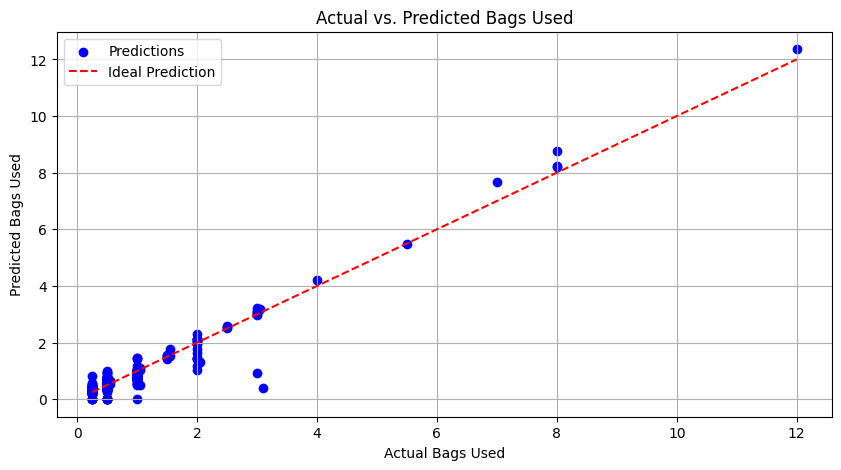

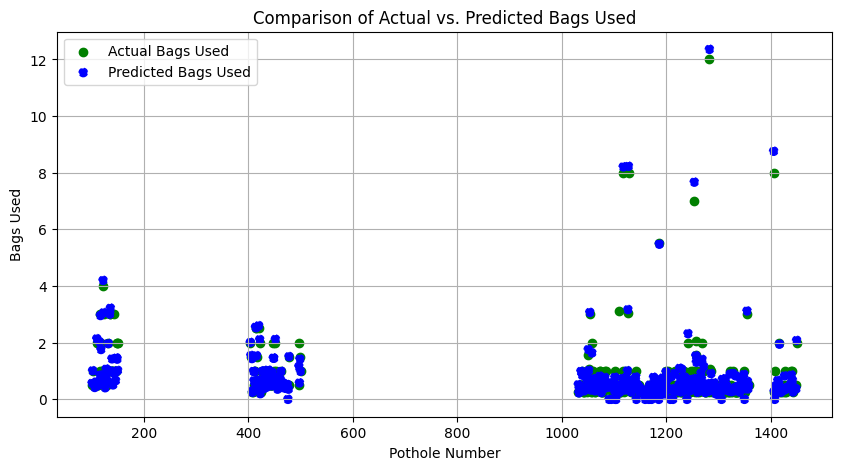

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

# Function to load prediction data from a .txt file and convert it into a feature vector
def load_prediction_data(file_path):
    with open(file_path, "r") as file:
        # Read all lines, skipping the header
        lines = file.readlines()

    # Extract and flatten the numeric values from each line
    features = []
    for line in lines:
        values = line.strip().split(",")[1:]  # Skip the first column (box number)
        features.extend([float(v) for v in values])

    return np.array(features)

# Load the saved model
model = tf.keras.models.load_model("drive/MyDrive/data/bags_used_predictor.keras", custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

# Directory where the .txt files are located
predictions_directory = "drive/MyDrive/data/predictions/"

# List to store the predictions
predictions = []

# Loop through each .txt file in the directory
for txt_file in os.listdir(predictions_directory):
    if txt_file.endswith(".txt"):
        txt_file_path = os.path.join(predictions_directory, txt_file)

        # Load and preprocess the .txt file
        input_features = load_prediction_data(txt_file_path)
        input_features = np.array(input_features)
        input_features = input_features.reshape(1, -1)

        # Use the model to predict the bags_used value
        predicted_bags_used = model.predict(input_features, verbose=0)

        # Extract the file number (e.g., 'p101.txt' -> '101')
        file_number = int(txt_file.replace("p", "").replace(".txt", ""))

        # Store the result in the predictions list
        predictions.append([file_number, round(abs(predicted_bags_used[0][0]), 2)])

# Sort the predictions by file number
predictions.sort(key=lambda x: x[0])

# Specify the output CSV file path
output_csv_path = "drive/MyDrive/data/train_labels_check.csv"

# Save the predictions to a CSV file
with open(output_csv_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write the header
    writer.writerow(["Pothole number", "Bags used"])
    # Write the predictions
    writer.writerows(predictions)

print(f"Predictions saved to {output_csv_path}")

# Load the CSV files into DataFrames
df_train = pd.read_csv("drive/MyDrive/data/train_labels.csv")
df_check = pd.read_csv(output_csv_path)

# Ensure both files have consistent column names
df_train.columns = ["Pothole number", "Bags used"]
df_check.columns = ["Pothole number", "Bags used"]

# Merge the DataFrames on "Pothole number" to align the corresponding entries
merged_df = pd.merge(df_train, df_check, on="Pothole number", suffixes=('_train', '_check'))

# Extract the "Bags used" columns for comparison
y_true = merged_df["Bags used_train"]  # Use corrected column name
y_pred = merged_df["Bags used_check"]

# Calculate the R² and MSE errors
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f"R² error between the two files: {r2:.4f}")
print(f"Mean Squared Error (MSE) between the two files: {mse:.4f}")



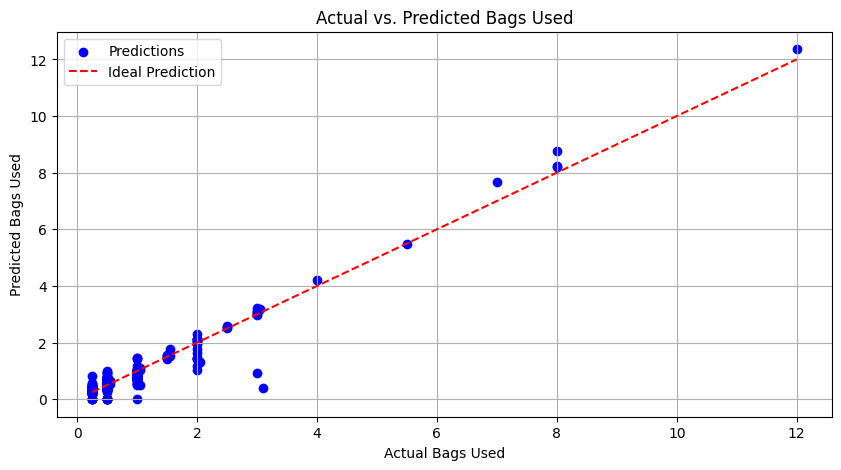

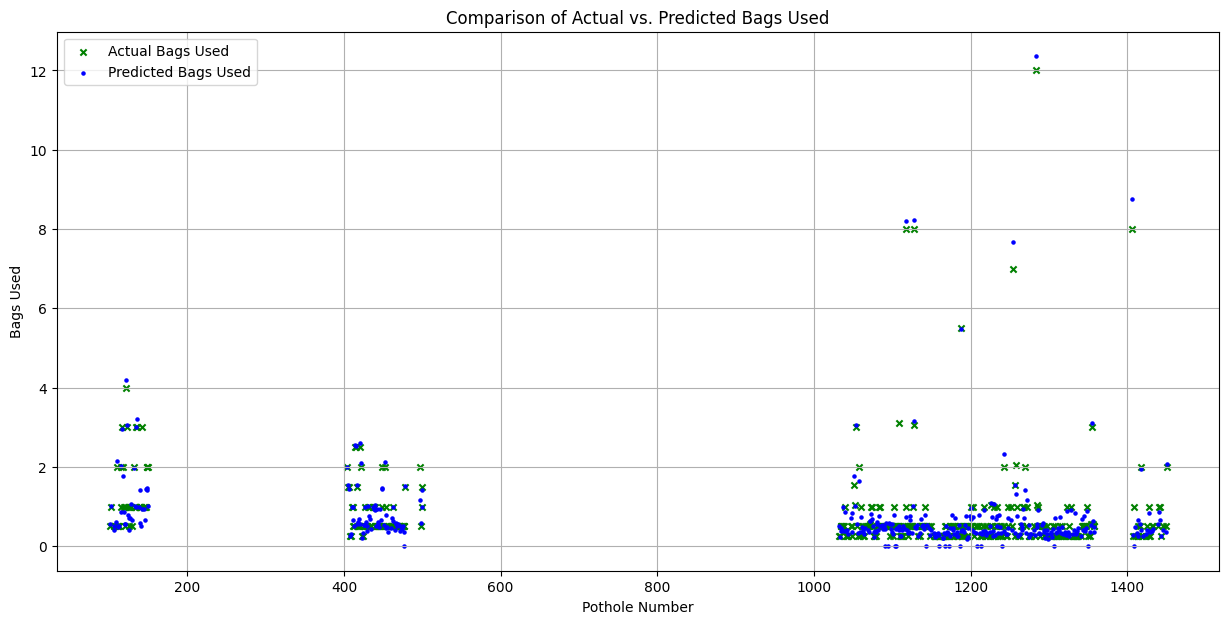

In [ ]:
# Plotting the results

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_true, y_pred, color='blue', label="Predictions")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', label="Ideal Prediction")
plt.xlabel("Actual Bags Used")
plt.ylabel("Predicted Bags Used")
plt.title("Actual vs. Predicted Bags Used")
plt.legend()
plt.grid(True)
plt.show()

# Line plot of actual vs. predicted values
plt.figure(figsize=(15, 7))
plt.scatter(merged_df["Pothole number"], y_true, label="Actual Bags Used", color='green', marker = 'x', s = 20)
plt.scatter(merged_df["Pothole number"], y_pred, label="Predicted Bags Used", color='blue', s = 5)
plt.xlabel("Pothole Number")
plt.ylabel("Bags Used")
plt.title("Comparison of Actual vs. Predicted Bags Used")
plt.legend()
plt.grid(True)
plt.show()

## Use NN to Predict Bags Used for Test Images

In [ ]:
# Function to load prediction data from a .txt file and convert it into a feature vector
def load_prediction_data(file_path):
    with open(file_path, "r") as file:
        # Read all lines, skipping the header
        lines = file.readlines()

    # Extract and flatten the numeric values from each line
    features = []
    for line in lines:
        values = line.strip().split(",")[1:]  # Skip the first column (box number)
        features.extend([float(v) for v in values])

    return np.array(features)

# Load the saved model
model = tf.keras.models.load_model("drive/MyDrive/data/bags_used_predictor.keras")

# Directory where the .txt files are located
predictions_directory = "drive/MyDrive/data/predictions_test/"

# List to store the predictions
predictions = []
scaler = joblib.load('scaler.pkl')
label_scaler = joblib.load('label_scaler.pkl')

# Loop through each .txt file in the directory
for txt_file in os.listdir(predictions_directory):
    if txt_file.endswith(".txt"):
        txt_file_path = os.path.join(predictions_directory, txt_file)

        # Load and preprocess the .txt file
        input_features = load_prediction_data(txt_file_path)
        input_features = np.array(input_features)

        input_features = input_features.reshape(1,-1)

        # Use the model to predict the bags_used value
        predicted_bags_used = model.predict(input_features, verbose=0)

        # Extract the file number (e.g., 'p101.txt' -> '101')
        file_number = int(txt_file.replace("p", "").replace(".txt", ""))

        # Store the result in the predictions list
        predictions.append([file_number, round(abs(predicted_bags_used[0][0]), 2)])

# Sort the predictions by file number
predictions.sort(key=lambda x: x[0])

# Specify the output CSV file path
output_csv_path = "drive/MyDrive/data/test_labels.csv"

# Save the predictions to a CSV file
with open(output_csv_path, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Write the header
    writer.writerow(["Pothole number", "Bags used "])
    # Write the predictions
    writer.writerows(predictions)

print(f"Predictions saved to {output_csv_path}")
for i in range(len(predictions)):
    print(predictions[i])

Predictions saved to drive/MyDrive/data/test_labels.csv
[103, 0.75]
[104, 1.0]
[105, 0.75]
[108, 1.0]
[114, 1.0]
[143, 0.5]
[144, 0.5]
[406, 1.0]
[434, 7.5]
[450, 1.0]
[470, 0.75]
[473, 0.5]
[479, 0.75]
[1040, 0.5]
[1086, 0.5]
[1115, 0.5]
[1134, 0.25]
[1161, 0.25]
[1162, 0.25]
[1181, 0.75]
[1198, 0.5]
[1205, 0.5]
[1250, 0.25]
[1270, 0.5]
[1278, 0.25]
[1280, 0.25]
[1296, 0.25]
[1409, 0.25]
[1430, 0.5]
[1438, 0.5]
